In [1]:
# NUMPY
import numpy as np

# MATPLOTLIB
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# POT
import ot
from ot import sinkhorn
# from ot.bregman import sinkhorn, greenkhorn

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL'
sys.path.insert(0, path_files) 

# GREENKHORN 
from greenkhorn.sinkhorn import sinkhorn as sinkhgreen
# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn
# np.random.seed(3946)

## Data generation

In [2]:
n_1 = 200# nb samples
n_2 = 100
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.01

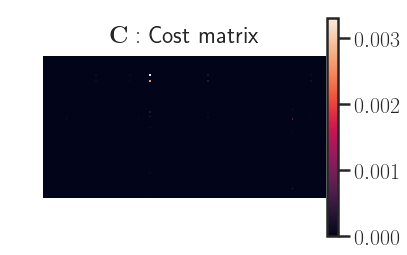

In [3]:
cb_padding = 0.005
fig, ax = plt.subplots(ncols=1) #, figsize=(20,20))
I1 = ax.matshow(np.exp(-M.T/reg))
ax.set_title(r'$\mathbf{C}:$ Cost matrix ')
ax.axis('off')
fig.colorbar(I1, ax=ax, pad=cb_padding, orientation="vertical")
ax.label_outer()

## Greenkhorn from POT

In [4]:
# P_green = greenkhorn(a, b, M, reg, numItermax=1000, stopThr=1e-09, verbose=False, log=False)
# P_green

## Greenkhorn from Altshuler et al

In [5]:
# P_green, _, _ = sinkhgreen(M, a, b, False, M, max_iter=1000)
# (A, r, c, compute_otvals, C, max_iter):
# P_green

## Sinkhorn's algorithm from POT

In [6]:
P_sink = sinkhorn(a, b, M, reg, log=True)

In [7]:
# Print P^star, u_sink = e^{u^star}, v_sink = e^{v^star}
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']

In [8]:
exp_u_star.shape, P_star.shape, exp_v_star.shape

((200,), (200, 100), (100,))

## Direct Implementation of Sinkhorn

In [9]:
def sinkhorn_direct(a, b, M, reg, max_iter=5000):
    (n, m) = M.shape
    u_k = np.ones(n)
    v_k = np.ones(m)
    max_iter = 1001
    K = np.exp(-M/reg)
    for k in range(max_iter):
        u_k = np.divide(a, K @ v_k)
        v_k = np.divide(b, K.T @ u_k)
        P_k = (np.diag(u_k) @ K) @ np.diag(v_k) # .reshape(-1)
        sinkhorn_distance = np.sqrt(sum(sum(np.multiply(P_k, K))))
        return P_k, u_k, v_k

In [10]:
# P_direct = sinkhorn_direct(mu, nu, C, eta, max_iter=5001)
P_direct, u_direct, v_direct = sinkhorn_direct(a, b, M, reg, max_iter=1000)

In [11]:
u_direct.shape, P_direct.shape, v_direct.shape

((200,), (200, 100), (100,))

## Some plots to get the difference between $P^\star$ from the POT and direct implementation

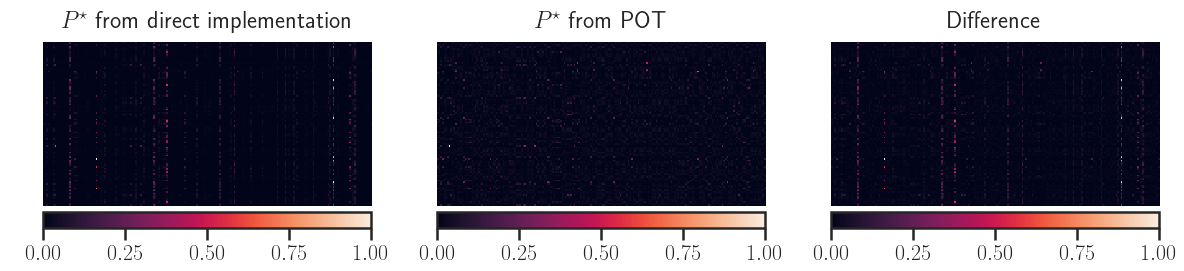

In [12]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_direct.T, P_direct.max()))
ax1.set_title(r'$P^\star$ from direct implementation')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide(P_star.T, P_star.max()))
ax2.set_title(r'$P^\star$ from POT');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(np.divide(np.abs(P_direct.T - P_star.T) , np.abs(P_direct.T - P_star.T).max()))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

## Screenkhorn

In [13]:
# Initialization
# epsilon = 1e-19
epsilon = 0.
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

### Plots of $e^{u^\star}$ and $e^{v^\star}$ from POT

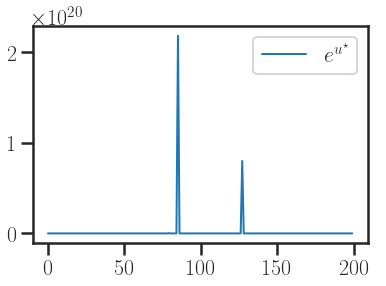

In [14]:
#plt.yscale('log')
plt.plot(exp_u_star, linewidth=2, label=r'$e^{u^\star}$');
plt.legend();

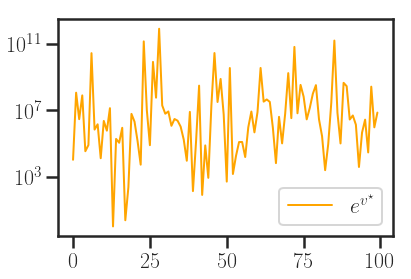

In [15]:
plt.yscale('log')
plt.plot(exp_v_star, linewidth=2, color='orange', label=r'$e^{v^\star}$');
plt.legend();

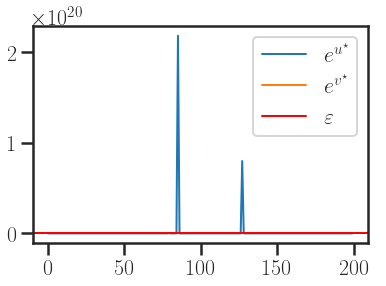

In [16]:
# plt.yscale('log')
plt.plot(exp_u_star, linewidth=2, label=r'$e^{u^\star}$')
plt.plot(exp_v_star, linewidth=2, label=r'$e^{v^\star}$') 
plt.axhline(y= epsilon, linewidth=2, color='r', label=r'$\varepsilon$')
plt.legend();

### $\ell_2$-norm of $e^{u^\star}$ and $e^{v^\star}$

In [17]:
norm2exp_u_star = np.linalg.norm(exp_u_star)
norm2exp_v_star  = np.linalg.norm(exp_v_star)
norm2exp_u_star, "---------", norm2exp_v_star #, norm2exp_u_star / norm2exp_v_star

(2.32391047430647e+20, '---------', 816403757107.318)

### Plots of $u^\star$ and $v^\star$

/Users/mzalaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


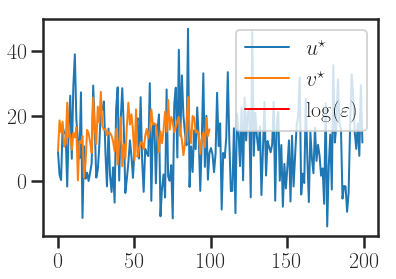

In [18]:
u_star = np.log(exp_u_star)
v_star = np.log(exp_v_star)

plt.plot(u_star , linewidth=2, label=r'${u^\star}$')
plt.plot(v_star , linewidth=2, label=r'${v^\star}$') 
plt.axhline(y =np.log(epsilon), linewidth=2, color='r', label=r'$\log(\varepsilon)$')
plt.legend(loc='best');

### Choosing of the intervals $I_u$ and $J_u$

In [19]:
I = np.where(exp_u_star >= epsilon)[0].tolist()
#Ic = np.where(exp_v_star < epsilon)[0].tolist()
#len(I), len(Ic)
#Ic

In [20]:
J = np.where(exp_v_star >= epsilon)[0].tolist()
#Jc = np.where(exp_v_star < epsilon)[0].tolist()
#len(J), len(Jc)

In [21]:
# Objective function
# obj = screenkhorn.objective(u_star, v_star, I, J)
# obj

In [22]:
# grad = screenkhorn.grad_objective(u_star, v_star, I, J)
# grad[0], grad[1]

### `screenkhorn = Screening Sinkhorn` potentials vectors by Projected Gradient Descent algorithm

In [23]:
proj_grad = screenkhorn.projected_grad(I, J, max_iter=1000, tol=1e-10, verbose=False)
# proj_grad

/Users/mzalaya/PycharmProjects/OATMIL/screenkhorn/screenkhorn.py:420: RuntimeWarning: divide by zero encountered in log
  z_uc = np.array([np.log(self.epsilon)] * len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/screenkhorn/screenkhorn.py:421: RuntimeWarning: divide by zero encountered in log
  z_vc = np.array([np.log(self.epsilon)] * len(Jc))
/Users/mzalaya/PycharmProjects/OATMIL/screenkhorn/screenkhorn.py:82: RuntimeWarning: divide by zero encountered in log
  u_param_Ic = np.array([np.log(self.epsilon)] * card_Ic)
/Users/mzalaya/PycharmProjects/OATMIL/screenkhorn/screenkhorn.py:83: RuntimeWarning: divide by zero encountered in log
  v_param_Jc =  np.array([np.log(self.epsilon)] * card_Jc)


iter: 0 obj:  1.869248e-03, dif: 4.891288e-03
iter: 1 obj: -5.467257e-03, dif: 7.336504e-03
iter: 2 obj: -1.427034e-02, dif: 8.803086e-03
iter: 3 obj: -2.405061e-02, dif: 9.780265e-03
iter: 4 obj: -3.452835e-02, dif: 1.047774e-02
iter: 5 obj: -4.552873e-02, dif: 1.100038e-02
iter: 6 obj: -5.693517e-02, dif: 1.140644e-02
iter: 7 obj: -6.866606e-02, dif: 1.173089e-02
iter: 8 obj: -8.066202e-02, dif: 1.199596e-02
iter: 9 obj: -9.287853e-02, dif: 1.221651e-02
iter: 10 obj: -1.052813e-01, dif: 1.240280e-02
iter: 11 obj: -1.178435e-01, dif: 1.256216e-02
iter: 12 obj: -1.305435e-01, dif: 1.269998e-02
iter: 13 obj: -1.433638e-01, dif: 1.282029e-02
iter: 14 obj: -1.562899e-01, dif: 1.292618e-02
iter: 15 obj: -1.693100e-01, dif: 1.302005e-02
iter: 16 obj: -1.824138e-01, dif: 1.310380e-02
iter: 17 obj: -1.955927e-01, dif: 1.317893e-02
iter: 18 obj: -2.088394e-01, dif: 1.324669e-02
iter: 19 obj: -2.221475e-01, dif: 1.330807e-02
iter: 20 obj: -2.355114e-01, dif: 1.336390e-02
iter: 21 obj: -2.489263

iter: 182 obj: -2.508882e+00, dif: 1.397882e-02
iter: 183 obj: -2.522857e+00, dif: 1.397592e-02
iter: 184 obj: -2.536830e+00, dif: 1.397301e-02
iter: 185 obj: -2.550801e+00, dif: 1.397008e-02
iter: 186 obj: -2.564768e+00, dif: 1.396714e-02
iter: 187 obj: -2.578732e+00, dif: 1.396418e-02
iter: 188 obj: -2.592693e+00, dif: 1.396121e-02
iter: 189 obj: -2.606651e+00, dif: 1.395822e-02
iter: 190 obj: -2.620607e+00, dif: 1.395522e-02
iter: 191 obj: -2.634559e+00, dif: 1.395221e-02
iter: 192 obj: -2.648508e+00, dif: 1.394918e-02
iter: 193 obj: -2.662454e+00, dif: 1.394614e-02
iter: 194 obj: -2.676397e+00, dif: 1.394309e-02
iter: 195 obj: -2.690337e+00, dif: 1.394002e-02
iter: 196 obj: -2.704274e+00, dif: 1.393694e-02
iter: 197 obj: -2.718208e+00, dif: 1.393385e-02
iter: 198 obj: -2.732139e+00, dif: 1.393074e-02
iter: 199 obj: -2.746066e+00, dif: 1.392762e-02
iter: 200 obj: -2.759991e+00, dif: 1.392449e-02
iter: 201 obj: -2.773912e+00, dif: 1.392135e-02
iter: 202 obj: -2.787830e+00, dif: 1.391

iter: 360 obj: -4.940318e+00, dif: 1.328902e-02
iter: 361 obj: -4.953602e+00, dif: 1.328416e-02
iter: 362 obj: -4.966881e+00, dif: 1.327928e-02
iter: 363 obj: -4.980156e+00, dif: 1.327439e-02
iter: 364 obj: -4.993425e+00, dif: 1.326949e-02
iter: 365 obj: -5.006690e+00, dif: 1.326458e-02
iter: 366 obj: -5.019949e+00, dif: 1.325965e-02
iter: 367 obj: -5.033204e+00, dif: 1.325471e-02
iter: 368 obj: -5.046454e+00, dif: 1.324977e-02
iter: 369 obj: -5.059699e+00, dif: 1.324481e-02
iter: 370 obj: -5.072939e+00, dif: 1.323983e-02
iter: 371 obj: -5.086173e+00, dif: 1.323485e-02
iter: 372 obj: -5.099403e+00, dif: 1.322985e-02
iter: 373 obj: -5.112628e+00, dif: 1.322485e-02
iter: 374 obj: -5.125848e+00, dif: 1.321983e-02
iter: 375 obj: -5.139063e+00, dif: 1.321480e-02
iter: 376 obj: -5.152273e+00, dif: 1.320975e-02
iter: 377 obj: -5.165477e+00, dif: 1.320470e-02
iter: 378 obj: -5.178677e+00, dif: 1.319963e-02
iter: 379 obj: -5.191871e+00, dif: 1.319456e-02
iter: 380 obj: -5.205061e+00, dif: 1.318

iter: 622 obj: -8.233461e+00, dif: 1.182452e-02
iter: 623 obj: -8.245279e+00, dif: 1.181866e-02
iter: 624 obj: -8.257092e+00, dif: 1.181280e-02
iter: 625 obj: -8.268899e+00, dif: 1.180693e-02
iter: 626 obj: -8.280700e+00, dif: 1.180106e-02
iter: 627 obj: -8.292495e+00, dif: 1.179518e-02
iter: 628 obj: -8.304285e+00, dif: 1.178930e-02
iter: 629 obj: -8.316068e+00, dif: 1.178341e-02
iter: 630 obj: -8.327845e+00, dif: 1.177752e-02
iter: 631 obj: -8.339617e+00, dif: 1.177162e-02
iter: 632 obj: -8.351383e+00, dif: 1.176572e-02
iter: 633 obj: -8.363143e+00, dif: 1.175981e-02
iter: 634 obj: -8.374897e+00, dif: 1.175390e-02
iter: 635 obj: -8.386645e+00, dif: 1.174799e-02
iter: 636 obj: -8.398387e+00, dif: 1.174207e-02
iter: 637 obj: -8.410123e+00, dif: 1.173614e-02
iter: 638 obj: -8.421853e+00, dif: 1.173021e-02
iter: 639 obj: -8.433577e+00, dif: 1.172427e-02
iter: 640 obj: -8.445296e+00, dif: 1.171833e-02
iter: 641 obj: -8.457008e+00, dif: 1.171239e-02
iter: 642 obj: -8.468714e+00, dif: 1.170

iter: 809 obj: -1.033525e+01, dif: 1.062436e-02
iter: 810 obj: -1.034587e+01, dif: 1.061739e-02
iter: 811 obj: -1.035648e+01, dif: 1.061041e-02
iter: 812 obj: -1.036708e+01, dif: 1.060343e-02
iter: 813 obj: -1.037768e+01, dif: 1.059645e-02
iter: 814 obj: -1.038827e+01, dif: 1.058946e-02
iter: 815 obj: -1.039885e+01, dif: 1.058246e-02
iter: 816 obj: -1.040943e+01, dif: 1.057547e-02
iter: 817 obj: -1.041999e+01, dif: 1.056846e-02
iter: 818 obj: -1.043056e+01, dif: 1.056146e-02
iter: 819 obj: -1.044111e+01, dif: 1.055444e-02
iter: 820 obj: -1.045166e+01, dif: 1.054743e-02
iter: 821 obj: -1.046220e+01, dif: 1.054041e-02
iter: 822 obj: -1.047273e+01, dif: 1.053339e-02
iter: 823 obj: -1.048326e+01, dif: 1.052636e-02
iter: 824 obj: -1.049378e+01, dif: 1.051933e-02
iter: 825 obj: -1.050429e+01, dif: 1.051229e-02
iter: 826 obj: -1.051479e+01, dif: 1.050525e-02
iter: 827 obj: -1.052529e+01, dif: 1.049821e-02
iter: 828 obj: -1.053578e+01, dif: 1.049116e-02
iter: 829 obj: -1.054627e+01, dif: 1.048

iter: 996 obj: -1.219620e+01, dif: 9.276791e-03
iter: 997 obj: -1.220547e+01, dif: 9.269526e-03
iter: 998 obj: -1.221473e+01, dif: 9.262262e-03
iter: 999 obj: -1.222398e+01, dif: 9.255000e-03
Total time taken:  4.556229
compteur 0


### Curve of the objective function

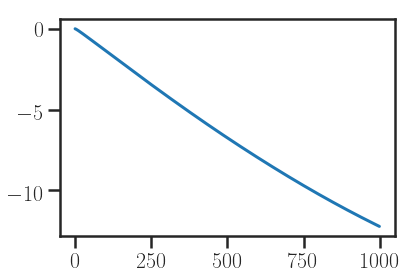

In [24]:
obj = list(proj_grad[2].values())

obj = np.asarray(obj)
obj = obj.T
obj.shape = (len(obj,))
plt.plot(obj);

### Sort of the solution by `screenkhorn` $e^{u_\text{sc}}$

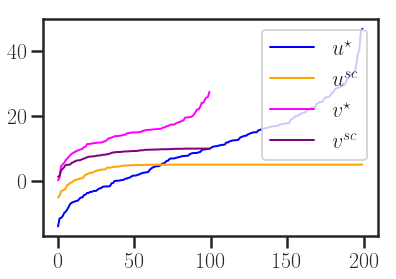

In [25]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad[0]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad[1]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
plt.legend();

## Verification of $$e^{{u_\text{sc}}_{I_u}} = \log(\varepsilon)$$

In [26]:
# x[Ic] == np.log(epsilon)

## Estimated marginals 

$$ P^{sc} = \Delta(e^{u_{sc}}) K \Delta(e^{v_{sc}})$$

In [27]:
# e^{u_{\text{sc}} K e^{v_{\text{sc}}$$
## Marginals 
K = np.exp(- screenkhorn.M / screenkhorn.reg)
u_sc = proj_grad[0]
u_sc.shape=(n_1,)
v_sc = proj_grad[1]
v_sc.shape=(n_2,)
P_sc = np.diag(np.exp(u_sc)) @ K @ np.diag(np.exp(v_sc))
# P_star[:20], "\n", P_sc[:20]

In [28]:
norm2u_sc = np.linalg.norm(np.exp(u_sc))
norm2v_sc = np.linalg.norm(np.exp(v_sc))

print(norm2u_sc, "\t", norm2exp_u_star)
print("\n")
print(norm2v_sc, "\t", norm2exp_v_star)

print("\n")
print(norm2u_sc / norm2v_sc, "\t", norm2exp_u_star /norm2exp_v_star)

1746.9383514677477 	 2.32391047430647e+20


122633.25163281201 	 816403757107.318


0.014245225729628563 	 284652104.31423664


### Gap between true and estimated marginals 

In [29]:
a_sc = P_sc @ np.ones(len(v_sc))
b_sc = P_sc.T @ np.ones(len(u_sc))
# print(np.abs(a - a_sc))
#plt.plot(a)
#plt.plot(np.abs(a - a_sc));
# print('-------------- Marginals giv')

print(a[:30]) 
print("\n")
print(a_sc[:30]) 
print("\n")
sum(a_sc)

[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005]


[2.96194679e-06 1.26439601e-03 1.32360495e-03 2.71724686e-09
 5.68805611e-09 1.32277006e-08 5.01388160e-03 9.13379748e-11
 8.95314802e-14 1.23351616e-05 2.68552021e-14 5.94594813e-18
 4.31685464e-10 1.12742489e-07 1.91454562e-05 2.41545157e-13
 1.05742828e-02 6.44895721e-07 1.98858062e-03 6.54376085e-04
 3.77832647e-03 4.34805739e-04 6.86699671e-05 4.28487771e-14
 1.18861325e-09 2.25276912e-03 1.80080434e-04 1.26850070e-07
 1.95489120e-11 6.92374473e-12]




0.34991456684336186

In [30]:
print(b[:30]) 
print("\n")
print(b_sc[:30]) 
print("\n")
sum(b_sc)
#b[:30] - b_sc[:30]

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]


[6.67638034e-03 4.48209709e-04 2.29003949e-03 9.46496438e-04
 6.43409299e-03 6.32502384e-03 2.31683165e-06 4.48533202e-03
 3.57330806e-03 6.93088853e-03 3.77426423e-03 4.98153720e-03
 2.35376686e-03 9.10548327e-03 5.67073482e-03 6.06958308e-03
 4.04986645e-03 8.80266624e-03 9.39531070e-03 1.44089766e-03
 2.91390511e-03 6.17644856e-03 8.05717989e-03 2.39585524e-06
 1.56620678e-03 6.17131374e-03 6.06270249e-06 8.02202023e-04
 2.69959274e-07 1.65786060e-03]




0.3499145668433618

In [31]:
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

In [32]:
abs(sum(a_star) - sum(a_sc)),  "\n\n", abs(sum(a_sc) - 1)

(0.6500854331566388, '\n\n', 0.6500854331566381)

In [33]:
abs(1 - sum(b_star)), 1- sum(b_sc)

(3.3306690738754696e-16, 0.6500854331566381)

In [34]:

a[:30]- a_sc[:30]

array([ 4.99703805e-03,  3.73560399e-03,  3.67639505e-03,  4.99999728e-03,
        4.99999431e-03,  4.99998677e-03, -1.38816046e-05,  4.99999991e-03,
        5.00000000e-03,  4.98766484e-03,  5.00000000e-03,  5.00000000e-03,
        4.99999957e-03,  4.99988726e-03,  4.98085454e-03,  5.00000000e-03,
       -5.57428276e-03,  4.99935510e-03,  3.01141938e-03,  4.34562392e-03,
        1.22167353e-03,  4.56519426e-03,  4.93133003e-03,  5.00000000e-03,
        4.99999881e-03,  2.74723088e-03,  4.81991957e-03,  4.99987315e-03,
        4.99999998e-03,  4.99999999e-03])

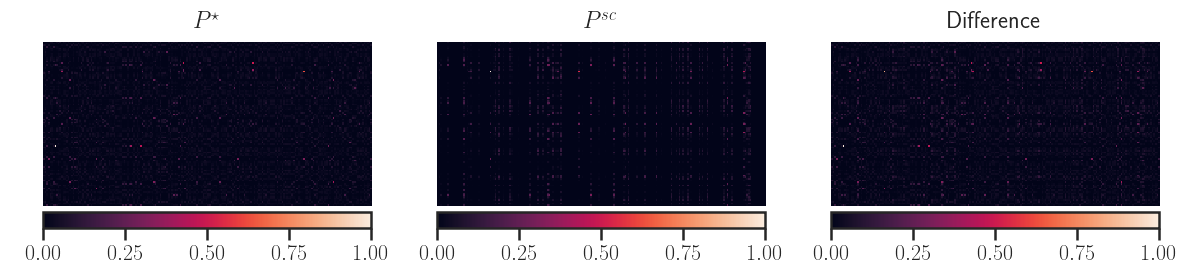

In [35]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_star.T, P_star.max()))
ax1.set_title(r'$P^\star$')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide( P_sc.T,  P_sc.T.max()))
ax2.set_title(r'$P^{sc}$');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(np.divide(np.abs(P_sc.T - P_star.T) , np.abs(P_sc.T - P_star.T).max()))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

In [36]:
P_sc[:5, :5]

array([[3.81353570e-10, 8.65587610e-13, 1.77033594e-08, 3.77811004e-15,
        5.61556657e-10],
       [6.33766140e-06, 5.84981604e-08, 9.47576543e-06, 2.12821380e-09,
        7.84226569e-06],
       [2.04191903e-05, 6.81204935e-07, 1.47045118e-09, 6.84313740e-06,
        1.22360087e-05],
       [2.93351683e-14, 1.99435640e-17, 4.41080672e-12, 3.68344544e-20,
        4.32623359e-14],
       [2.24639472e-10, 6.25560419e-13, 2.15164729e-13, 9.76347809e-13,
        1.36923614e-10]])

In [37]:
P_star[:5, :5]

array([[5.26901055e-07, 2.74276029e-07, 1.89005281e-04, 9.29415615e-10,
        1.11662304e-06],
       [9.03230785e-06, 1.91199819e-05, 1.04352054e-04, 5.40031465e-07,
        1.60850718e-05],
       [5.63123746e-06, 4.30842640e-05, 3.13352335e-09, 3.36011928e-04,
        4.85642687e-06],
       [1.10191033e-07, 1.71805083e-08, 1.28024385e-04, 2.46346287e-11,
        2.33872623e-07],
       [1.15315311e-04, 7.36454189e-05, 8.53471432e-07, 8.92358925e-05,
        1.01155852e-04]])